# 10.5 推定精度向上のためのテクニック
- MCMCはマルコフ連鎖の繰り返し数を無限にしたときに、理想的な性能を達成できる
- 現実では有限の繰り返しであるため、性能が劣化
- より少ない繰り返し数で性能を維持するために、アルゴリズムから実装に至るまで、様々な改善手法が提案されている。
    - レプリカ交換法・・・マルコフ連鎖による探索が局所的な領域から抜け出しにくくなる状況を回避する
- 本書ではMCMCを活用した一般状態空間モデルの推定に関する改善手法として、線形・ガウス型の状態空間モデルが部分的に当てはまる場合について説明を行う。

## 10.5.1 線形・ガウス型状態空間モデルが部分的に当てはまる場合
- 一般状態空間モデルにおいて、線形・ガウス型状態空間モデルが部分的に当てはまる場合がある。
    - カルマンフィルタを解法の部品として利用する
    - MCMCをカルマンフィルタでは解けない部分に集中
    - カルマンフィルタは解析解であり、推定精度の向上に寄与
- 本書では、このようなアプローチは可能であれば利用するべきである、という立場をとる

- このような方法が適用できるのは、一般状態空間モデルにおける状態が、線形・ガウス型状態空間モデルに従う部分とそれ以外の部分に分かれる場合
    - 例えば、パラメータが未知の線形・ガウス型状態空間モデルにおいて、パラメータを確率変数として考え、状態とパラメータの同時事後分布$p(x_{0:T},\theta|y_{1:T})$を推定する場合
    - パラメータさえわかってしまえば、線形・ガウス型の状態空間モデルとして考えることができる

1. 確率変数として考えているパラメータのみをMCMCで推定し、その推定結果をカルマンフィルタで利用する
    - MCMCで求める事後分布は$p(\theta|y_{1:T})$
    - ベイズの定理から、$p(\theta|y_{1:T}) \propto p(y_{1:T}|\theta) p(\theta) $
    - $ p(y_{1:T}|\theta)$は線形・ガウス型状態空間モデルの尤度(gaussian_dlm_obs())
    - $p(\theta)$は、事前情報がなければ無情報事前分布
    - こうして得られた$\theta$の推定結果の代表値を点推定値として、カルマンフィルタにプラグイン
1. あくまで同時事後分布$p(x_{0:T}, \theta | y_{1:T})$からのサンプルを求める方法でFFBSを利用
    - ベイズの定理から$p(x_{0:T}, \theta | y_{1:T}) = p(x_{0:T}|\theta, y_{1:T}) p(\theta|y_{1:T})$
    - 1項目の$p(x_{0:T}|\theta, y_{1:T})$は$\theta$が既知という条件になっているため、線形・ガウス型モデルに従い、FFBSが利用できる
    - 2項目の$p(\theta|y_{1:T})$のサンプリングには、上の1.の方法を用いる
    - つまり、計算方法としては、最初に$p(\theta|y_{1:T})$のサンプリングを行い、そのあとFFBSを用いて1項目の$p(x_{0:T}|\theta, y_{1:T})$からサンプリングを行い、状態の標本を再生する
    - FFBSはdlmBSample()

- 結局、MCMCを用いるのはパラメータ推定の部分

## 10.5.2 例：人工的なローカルレベルモデル
- パラメータが未知の線形・ガウス型状態空間モデルにおいて、状態とパラメータを合わせて推定する例(2番目の方法)
- 状態の事前分布に関する平均と分散は既知

```
// model10-3.stan
// モデル：規定【ローカルレベルモデル、パラメータが未知、カルマンフィルタを活用】

data{
  int<lower=1>    t_max;   // 時系列長
  matrix[1, t_max]    y;   // 観測値

  matrix[1, 1]    G;       // 状態遷移行列・・・・・・・・・新しく追加！！！！！
  matrix[1, 1]    F;       // 観測行列・・・・・・・・・・・新しく追加！！！！！
  　　　　　　　　　　　　 // G, Fは線形・ガウス型状態空間モデルの尤度を計算する関数gaussian_dlm_obs()の引数として用いられる
               
  vector[1]      m0;       // 事前分布の平均
  cov_matrix[1]  C0;       // 事前分布の分散
}

parameters{
  cov_matrix[1]   W;       // 状態雑音の分散
  cov_matrix[1]   V;       // 観測雑音の分散
  　　　　　　　　　　　　 // 状態x0, xの記述が消えている
}

model{
  // 尤度の部分
  /* 線形・ガウス型状態空間モデルの尤度を求める関数 */
  y ~ gaussian_dlm_obs(F, G, V, W, m0, C0);

  // 事前分布の部分
  // x0, xに関する記述が消えている
  /* W, Vの事前分布：無情報事前分布（省略時のデフォルト設定を活用） */
}
```

In [1]:
#[MCMCを活用したローカルレベルモデルの平滑化(パラメータが未知、カルマンフィルタを活用)]

# 前処理
set.seed(123)
library(rstan)

 要求されたパッケージ StanHeaders をロード中です 

 要求されたパッケージ ggplot2 をロード中です 

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



In [2]:
# Stanの事前設定：コードのHDD保存、並列計算、フラフの縦横比

rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
theme_set(theme_get() + theme(aspect.ratio = 3/4))

In [3]:
load(file = "ArtifitialLocalLevelModel.RData")

In [4]:
# モデル：生成・コンパイル
stan_mod_out <- stan_model(file = "model10-3.stan")

In [5]:
# 平滑化：実行(サンプリング)
dim(mod$m0) <- 1
fit_scan <- sampling(object = stan_mod_out, 
                    data = list(t_max = t_max, y = matrix(y, nrow = 1),
                               G = mod$G, F = t(mod$F),
                               m0 = mod$m0, C0 = mod$C0),
                    pars = c("W", "V"),
                    seed = 123)

In [6]:
# 結果の確認
fit_scan

Inference for Stan model: model10-3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
W[1,1]    0.98    0.01 0.26    0.56    0.79    0.94    1.13    1.59  1965    1
V[1,1]    2.07    0.01 0.32    1.48    1.84    2.06    2.27    2.76  1934    1
lp__   -235.52    0.03 1.01 -238.13 -235.94 -235.22 -234.79 -234.52  1611    1

Samples were drawn using NUTS(diag_e) at Fri Aug 06 17:56:22 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

- 実効サンプルサイズ(n_eff)はそれぞれ1965, 1934 / 4000 ・・・問題なし
- Rhatは1(<1.1)で問題なし
- W(状態雑音)の真値は1,推定結果は0.98・・・問題なし
- V(観測雑音)の真値は2,推定結果は2.07・・・問題なし

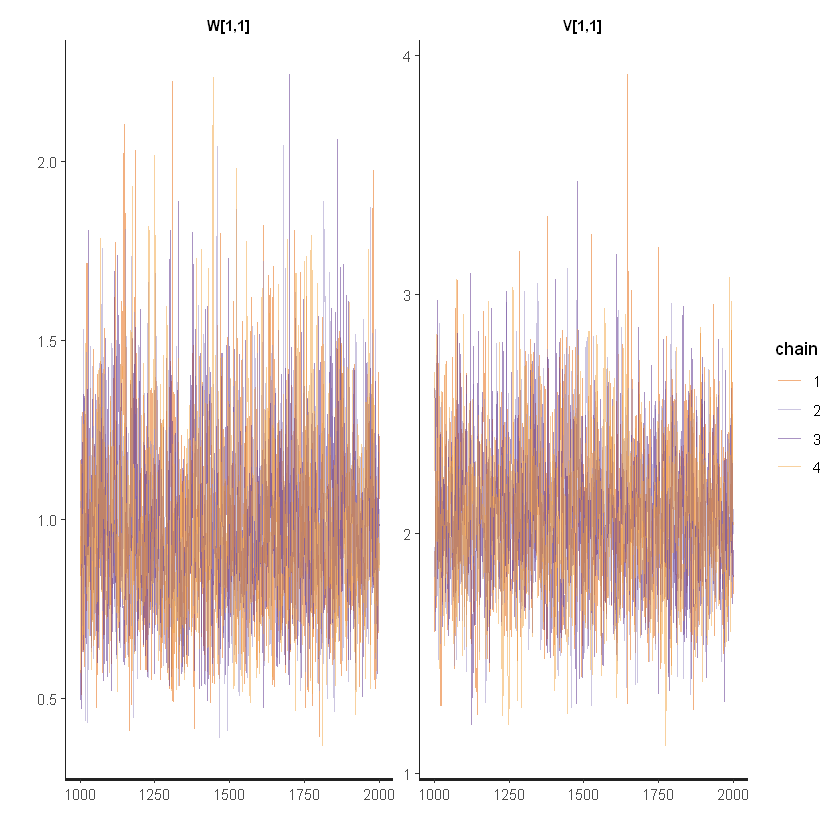

In [7]:
traceplot(fit_scan, pars = c("W", "V"), alpha = 0.5)

In [8]:
#[MCMCを活用したローカルレベルモデルの平滑化(FFBSで状態を再生)]

#前処理
set.seed(123)
library(dlm)


 次のパッケージを付け加えます: 'dlm' 


 以下のオブジェクトは 'package:ggplot2' からマスクされています: 

     %+% 




In [9]:
# 必要なサンプリング結果をとりだす
stan_mcmc_out <- rstan::extract(fit_scan, pars = c("W", "V"))

In [10]:
# FFBSの前処理：MCMCの繰り返しステップを設定、進捗バーの設定
it_seq <- seq_along(stan_mcmc_out$V[,1,1])
progress_bar <- txtProgressBar(min = 1, max = max(it_seq), style = 3)

In [11]:
# FFBSの本処理：状態の再生
x_FFBS <- sapply(it_seq, function(it){
    # 進捗バーの表示
    setTxtProgressBar(pb = progress_bar, value = it)
    
    # W, Vの値をモデルに設定
    mod$W[1,1] <- stan_mcmc_out$W[it, 1, 1]
    mod$V[1,1] <- stan_mcmc_out$V[it, 1, 1]
    
    # FFBSの実行
    return(dlmBSample(dlmFilter(y = y, mod = mod)))
})

  |======================================================================| 100%

- あるMCMCの繰り返しステップitにおける状態・観測雑音のサンプル値をモデルに設定し、dlmBSample()を用いて状態の標本を生成している。
- モデルの状態・観測雑音はMCMCの繰り返しステップごとに変わるため、関数dlmFilter()を毎回実行している

In [12]:
# FFBSの後処理：x0の分を除去して転置(Stanの出力と整合させて、列が時間方向)
x_FFBS <- t(x_FFBS[-1, ])

In [13]:
# 周辺化を行い、平均・25%値・75%値を求める
s_FFBS <- colMeans(x_FFBS)
s_FFBS_quant <- apply(x_FFBS, 2, FUN = quantile, probs = c(0.25, 0.75))

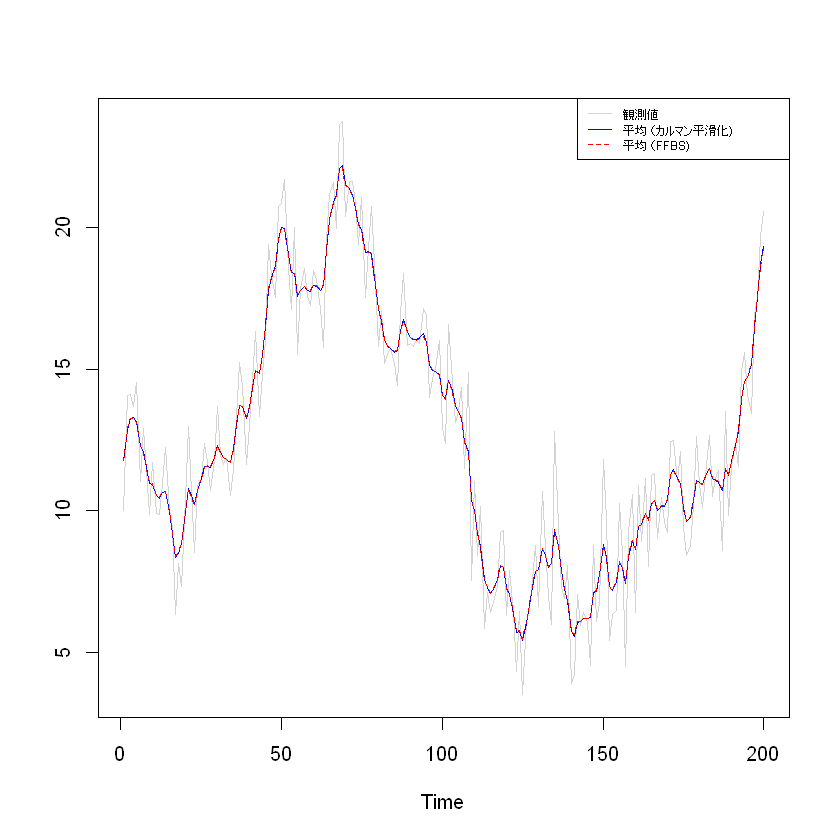

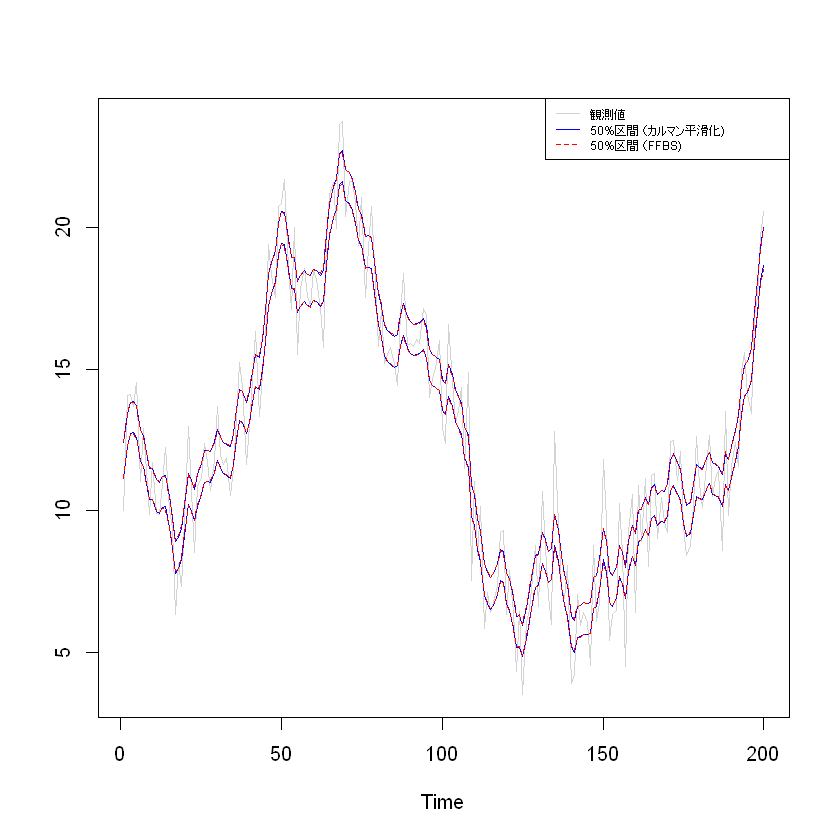

In [14]:
# 結果のプロット
ts.plot(cbind(y, s), col = c("lightgray", "blue"))
lines(s_FFBS, col = "red", lty = "dashed")

# 凡例
legend(legend = c("観測値", "平均 （カルマン平滑化)",  "平均 （FFBS)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 50, cex = 0.6)

# 結果のプロット
ts.plot(cbind(y, do.call("cbind", s_quant)),
        col = c("lightgray", "blue", "blue"))
lines(s_FFBS_quant["25%", ], col = "red", lty = "dashed")
lines(s_FFBS_quant["75%", ], col = "red", lty = "dashed")

# 凡例
legend(legend = c("観測値", "50%区間 （カルマン平滑化)",  "50%区間 （FFBS)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 60, cex = 0.6)

- FFBSの結果と、パラメータを全て既知とした場合のカルマン平滑化の結果を比較
- 両者の結果はほぼ一致